# Recommender System Content Based Filtering
Reference is taken from Andrew ng's notebook for Content Based Filtering

## Goal
In this recommender system we have some user ratings for some movies like in Collaborative filtering and additional information about users and movies , usig this information we will try to predict ratings for the movies which user has not rated and recommend those movies.

## Movie ratings dataset

The data set is derived from the MovieLens ml-latest-small dataset.

[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872]

The original dataset has 9000 movies rated by 600 users with ratings on a scale of 0.5 to 5 in 0.5 step increments. The dataset has been reduced in size to focus on movies from the years since 2000 and popular genres. The reduced dataset has Nu=395 users and Nm=694 movies. For each movie, the dataset provides a movie title, release date, and one or more genres. For example "Toy Story 3" was released in 2010 and has several genres: "Adventure|Animation|Children|Comedy|Fantasy|IMAX". This dataset contains little information about users other than their ratings. This dataset is used to create training vectors for the neural networks described below.

## Model : Content-based filtering with a neural network

Content-based filtering generates a user and movie feature vector but recognizes there may be other information available about the user and/or movie that may improve the prediction. The additional information is provided to a neural network which then generates the user and movie vector as shown below.

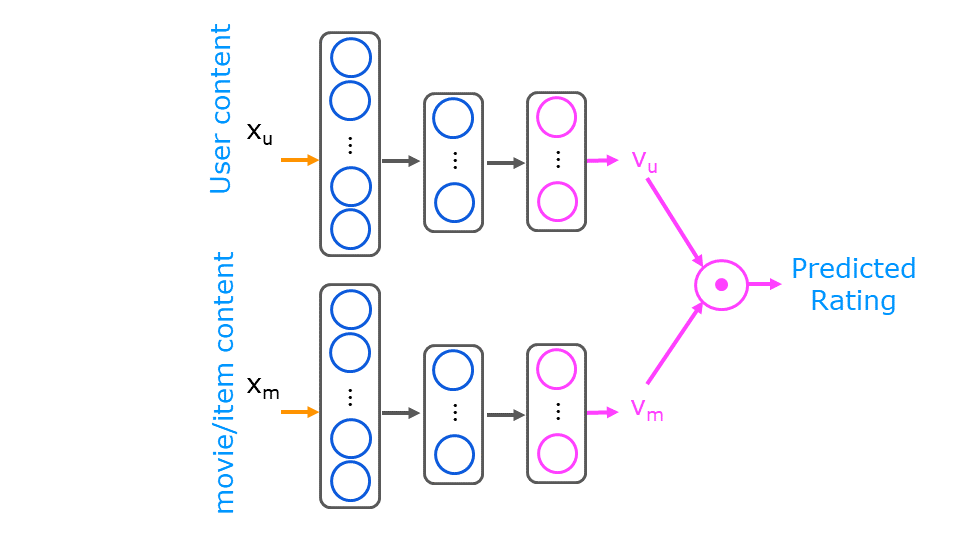

This model will take two inputs, user data and movie data( movies which are rated by user ) and will generate 1D vectors for both data and their dot product will give rating that user may give to the movie.

## Dataset Files
1. content_movie_list.csv : This file contains information of all movies. It has 3 columns : 'movie id','title' and 'genres'
<br>
2. content_user_to_genre.pickle : This file contains information of all the users. We will use following information:
                                      1. 'glist': Average rating of user for different genres of movies
                                      2. 'movies': Movie_id and rating that user has given
<br>
3. content_user_train_header.txt : Contains genres names for above 'glist' 
                                      

## Engineered features
We have to generate user data and movie data from above files for training our model.
<br>
Ex: users 1 rated 2 movies : deadpool with gernres: Action|Comedy|Sci-Fi and Logan with gernres Action|Sci-Fi
<br>
users 2 rated 2 movies : Save the Last Dance  with gernres: Drama|Romance and Wedding Planner with gernres Comedy|Romance

Training row:
<br>
user1| user1_glist | movie | movie_genre
<br>
usr1| user_1_glist | deadpool| Action
<br>
usr1| user_1_glist | deadpool| Comedy
<br>
usr1| user_1_glist | deadpool| Sci-Fi
<br>
usr1| user_1_glist | Logan| Action
<br>
usr1| user_1_glist | Logan| Sci-Fi
<br>
usr2| user_2_glist | Save the Last Dance| Drama
<br>
usr2| user_2_glist | Save the Last Dance| Romance
<br>
usr2| user_2_glist | Wedding Planner| Comedy
<br>
usr2| user_2_glist | Wedding Planner| Romance

<br>
All the user data will be in 'users' dataframe and all movies data will be in 'items' dataframe.
<br>
User data will be same for all the movies he/she rated.
<br> 
We will use One hot encoding for movie_genre
<br>
A training example for our model will be a row from users data and a row from items data and output will be prediction of rating that user may have given to the item or movie

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

!pip install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 1.4 MB/s eta 0:00:00


In [2]:
with open('../input/content-based-filtering-main/content_user_to_genre.pickle', 'rb') as f:
        user_to_genre = pickle.load(f)

movie_list=pd.read_csv('../input/content-based-filtering-main/content_movie_list.csv')

In [3]:
#Example data for user with user_id 2 
user_to_genre[2]

{'glist': array([[3.9  , 5.   , 0.   , 0.   , 4.   , 4.2  , 4.   , 4.   , 0.   ,
         3.   , 4.   , 0.   , 4.25 , 3.875]]),
 'g_count': array([[5., 1., 0., 0., 5., 5., 2., 9., 0., 1., 1., 0., 2., 8.]]),
 'rating_count': 16,
 'rating_sum': 65.0,
 'movies': {6874: 4.0,
  8798: 3.5,
  46970: 4.0,
  48516: 4.0,
  60756: 5.0,
  71535: 3.0,
  74458: 4.0,
  77455: 3.0,
  80489: 4.5,
  80906: 5.0,
  89774: 5.0,
  91658: 2.5,
  106782: 5.0,
  112552: 4.0,
  115713: 3.5,
  122882: 5.0},
 'rating_ave': 4.0625}

In [4]:
movie_list

,movieId,title,genres
0,4054,Save the Last Dance (2001),Drama|Romance
1,4069,"Wedding Planner, The (2001)",Comedy|Romance
2,4148,Hannibal (2001),Horror|Thriller
3,4149,Saving Silverman (Evil Woman) (2001),Comedy|Romance
4,4153,Down to Earth (2001),Comedy|Fantasy|Romance
...,...,...,...
689,168252,Logan (2017),Action|Sci-Fi
690,176371,Blade Runner 2049 (2017),Sci-Fi
691,177765,Coco (2017),Adventure|Animation|Children
692,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi


## Finding average ratings for all movies 

In [5]:
#creating sum of total rating col and count of total rating col
movie_list['total_rating_sum']=0
movie_list['total_rating_count']=0


In [6]:
#Disable warnings
pd.options.mode.chained_assignment = None  # default='warn'

#Calculating total ratings for each movies by looping through all users who gave ratings
for user in user_to_genre:
    #print(user_to_genre[user])
    #print(user['movies'])
    user_movies=user_to_genre[user]['movies']
    for movie in user_movies:
        #print(movie,user_movies[movie])
        movie_list.loc[:,'total_rating_sum'][movie_list['movieId']==movie]+=user_movies[movie]
        movie_list.loc[:,'total_rating_count'][movie_list['movieId']==movie]+=1
        
    

In [7]:
#Average rating =total_ratings/total_ratings_count
movie_list.loc[:,'avg rating']=movie_list.loc[:,'total_rating_sum'] / movie_list.loc[:,'total_rating_count']

In [8]:
#Deleting unwanted columns
movie_list.drop(['total_rating_sum','total_rating_count'],axis=1,inplace=True)

In [9]:
movie_list

,movieId,title,genres,avg rating
0,4054,Save the Last Dance (2001),Drama|Romance,2.843750
1,4069,"Wedding Planner, The (2001)",Comedy|Romance,2.909091
2,4148,Hannibal (2001),Horror|Thriller,2.935897
3,4149,Saving Silverman (Evil Woman) (2001),Comedy|Romance,2.772727
4,4153,Down to Earth (2001),Comedy|Fantasy|Romance,2.416667
...,...,...,...,...
689,168252,Logan (2017),Action|Sci-Fi,4.280000
690,176371,Blade Runner 2049 (2017),Sci-Fi,3.805556
691,177765,Coco (2017),Adventure|Animation|Children,3.538462
692,179819,Star Wars: The Last Jedi (2017),Action|Adventure|Fantasy|Sci-Fi,3.125000


In [10]:
my_item_vec=pd.DataFrame()
my_item_vec

""


## Splitting genres

In [11]:
#Splitting generes in each row and making rows for all generes and seperating year from title
for row in movie_list.values:
    categories=row[2].split('|')
    #print(categories)
    for category in categories:
        my_item_vec=my_item_vec.append({'movieId':row[0],'year':row[1][-5:-1],'ave rating':row[3],'title':row[1][:-7],'genres':category},ignore_index=True)
    
    
my_item_vec['movieId']=my_item_vec['movieId'].astype(int)

In [12]:
my_item_vec

,movieId,year,ave rating,title,genres
0,4054,2001,2.843750,Save the Last Dance,Drama
1,4054,2001,2.843750,Save the Last Dance,Romance
2,4069,2001,2.909091,"Wedding Planner, The",Comedy
3,4069,2001,2.909091,"Wedding Planner, The",Romance
4,4148,2001,2.935897,Hannibal,Horror
...,...,...,...,...,...
1878,179819,2017,3.125000,Star Wars: The Last Jedi,Fantasy
1879,179819,2017,3.125000,Star Wars: The Last Jedi,Sci-Fi
1880,187593,2018,3.875000,Deadpool 2,Action
1881,187593,2018,3.875000,Deadpool 2,Comedy


In [13]:
movie_list_seperated_genres=my_item_vec.copy()

## One Hot Encoding generes column

In [14]:
#one hot encoding generes column
from sklearn.preprocessing import OneHotEncoder
ohe_categories=OneHotEncoder(handle_unknown='ignore',sparse=False)
my_item_vec_categories=pd.DataFrame(ohe_categories.fit_transform(my_item_vec['genres'].to_numpy().reshape(-1,1))
                         ,columns=[col[3:] for col in ohe_categories.get_feature_names_out()]).astype(int)

In [15]:
my_item_vec=pd.concat([my_item_vec,my_item_vec_categories],axis=1)
my_item_vec.head()

,movieId,year,ave rating,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,4054,2001,2.843750,Save the Last Dance,Drama,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4054,2001,2.843750,Save the Last Dance,Romance,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4069,2001,2.909091,"Wedding Planner, The",Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4069,2001,2.909091,"Wedding Planner, The",Romance,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4148,2001,2.935897,Hannibal,Horror,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
#Dropping unwanted columns
my_item_vec.drop(['title','genres'],axis=1,inplace=True)

In [17]:
my_item_vec.head()

,movieId,year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,4054,2001,2.843750,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,4054,2001,2.843750,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,4069,2001,2.909091,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,4069,2001,2.909091,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4148,2001,2.935897,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Making training set : users and items

In [18]:
with open('../input/content-based-filtering-main/content_user_train_header.txt') as header:
    for line in header:
        #print(line[:-1].split(','))
        user_header=line[:-1].split(',')

In [19]:
users=pd.DataFrame([],columns=user_header)
items=pd.DataFrame([],columns=my_item_vec.columns)
y=pd.DataFrame([]) #actual ratings given by users

In [20]:
#We are creating training data so that there is 1 user that who has given rating to 1 item

for user in user_to_genre:


    #get all movie ids in list
    movie_dict=user_to_genre[user]['movies']
    
    #select data of all movies with above movie_ids in my_item_vec
    all_movies=my_item_vec[my_item_vec['movieId'].isin(movie_dict)].reset_index(drop=True)
    
    #select the ratings that user actually gave to the movies
    user_ratings=all_movies['movieId'].apply(lambda all_movies_movie_id:movie_dict[all_movies_movie_id])  #returns ratings given to movie by this user
    
    #Combining to original training data
    items=pd.concat([items,all_movies],axis=0,ignore_index=True)
    y=pd.concat([y,user_ratings],axis=0,ignore_index=True)
    
    
    #glist contains avg rating of user for different categories
    #combining user id, rating count and rating ave with glist
    combined_arr=np.c_[np.array([[user,user_to_genre[user]['rating_count'],user_to_genre[user]['rating_ave']]]),user_to_genre[user]['glist']]
    
    #No of movies rated
    num_repeat=all_movies.shape[0]
    
    #Repeat user data equal to no. of movie data the user has rated
    combined_arr_repeated=np.tile(combined_arr,(num_repeat,1))
    
 
    #Combining in original training data
    users=pd.concat([users,pd.DataFrame(combined_arr_repeated,columns=user_header)],axis=0,ignore_index=True)
        

In [21]:
#Converting year from object to float 
items['year']=items['year'].astype(int)

In [22]:
users.head()

,user id,rating count,rating ave,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,2.0,16.0,4.0625,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.25,3.875
1,2.0,16.0,4.0625,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.25,3.875
2,2.0,16.0,4.0625,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.25,3.875
3,2.0,16.0,4.0625,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.25,3.875
4,2.0,16.0,4.0625,3.9,5.0,0.0,0.0,4.0,4.2,4.0,4.0,0.0,3.0,4.0,0.0,4.25,3.875


In [23]:
items.head()

,movieId,year,ave rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller
0,6874,2003,3.961832,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6874,2003,3.961832,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,6874,2003,3.961832,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,8798,2004,3.761364,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8798,2004,3.761364,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [24]:
y.head()

,0
0,4.0
1,4.0
2,4.0
3,3.5
4,3.5


##### Above, we can see that movie 6874 is an action movie released in 2003. User 2 rates action movies as 3.9 on average. Further, movie 6874 was also listed in the Crime and Thriller genre. MovieLens users gave the movie an average rating of 3.9. A training example consists of a row from both tables and a rating from y_train.

## Processing training data

In [25]:
#In model we will not use first 3 columns from from users set i.e 'user id','rating count' and 'rating ave' 
user_features=[col for col in users.columns if col not in ['user id','rating count','rating ave'] ]
num_user_features=len(user_features)
user_features_start=3   #Model takes values from 3rd column to last column

#In model we will not use first column from items set i.e col 'movieId' 
item_features=[col for col in items.columns if col not in ['movieId'] ]
num_item_features=len(item_features)
item_features_start=1   #Model takes values from 1st column to last column

print('User features : ',num_user_features,' : ',user_features)
print('Item features : ',num_item_features,' : ',item_features)

User features :  14  :  ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']
Item features :  16  :  ['year', 'ave rating', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller']


## Scaling

In [26]:
#Scaling data
from sklearn.preprocessing import StandardScaler

scaledata=True
if scaledata:
    item_train_save = items.copy()
    user_train_save = users.copy()
    
    scaler_items=StandardScaler()
    items=pd.DataFrame(scaler_items.fit_transform(items),columns=items.columns)
    
    scaler_users=StandardScaler()
    users=pd.DataFrame(scaler_users.fit_transform(users),columns=users.columns)


In [27]:
#Splitting training and test data
from sklearn.model_selection import train_test_split

items_train,items_test=train_test_split(items,test_size=0.2,shuffle=True,random_state=1)
users_train,users_test=train_test_split(users,test_size=0.2,shuffle=True,random_state=1)
y_train,y_test=train_test_split(y,test_size=0.2,shuffle=True,random_state=1)


In [28]:
#Scale the target ratings using a Min Max Scaler to scale the target to be between -1 and 1. We use scikit-learn because it has an inverse_transform. 
from sklearn.preprocessing import MinMaxScaler

y_scaler=MinMaxScaler((-1,1))
y_train_norm=y_scaler.fit_transform(y_train)
y_test_norm=y_scaler.transform(y_test)

## Making model : Neural Network for content-based filtering
Now, let's construct a neural network as described in the figure above. It will have two networks that are combined by a dot product. You will construct the two networks. In this example, they will be identical. Note that these networks do not need to be the same. If the user content was substantially larger than the movie content, you might elect to increase the complexity of the user network relative to the movie network. In this case, the content is similar, so the networks are the same.

Use a Keras sequential model
The first layer is a dense layer with 256 units and a relu activation.
The second layer is a dense layer with 128 units and a relu activation.
The third layer is a dense layer with num_outputs units and a linear or no activation.

In [29]:
#Making Model
num_outputs=32
tf.random.set_seed(1)

users_NN=tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(num_outputs,activation='linear'),
])

items_NN=tf.keras.models.Sequential([
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(num_outputs,activation='linear'),
])


# create the user input and point to the base network
users_input=tf.keras.layers.Input(shape=(num_user_features))
vu=users_NN(users_input)
vu=tf.linalg.l2_normalize(vu,axis=1)

# create the item input and point to the base network
items_input=tf.keras.layers.Input(shape=(num_item_features))
vm=items_NN(items_input)
vm=tf.linalg.l2_normalize(vm,axis=1)

# compute the dot product of the two vectors vu and vm
output=tf.keras.layers.Dot(axes=1)([vu,vm])

#Specify input and output of model
model=tf.keras.Model([users_input,items_input],output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           40864       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 32)           41376       input_2[0][0]                    
______________________________________________________________________________________________

2022-09-12 12:51:58.448770: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [30]:
tf.random.set_seed(1)
cost_fun=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss=cost_fun,optimizer=optimizer)

In [31]:
model.fit([users_train[user_features],items_train[item_features]],y_train_norm,epochs=30)

2022-09-12 12:51:58.845750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
1455/1455 [==============================] - 6s 3ms/step - loss: 0.1253
Epoch 2/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1182
Epoch 3/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1167
Epoch 4/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1150
Epoch 5/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1141
Epoch 6/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1127
Epoch 7/30
1455/1455 [==============================] - 6s 4ms/step - loss: 0.1120
Epoch 8/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1113
Epoch 9/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1103
Epoch 10/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1098
Epoch 11/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1081
Epoch 12/30
1455/1455 [==============================] - 5s 3ms/step - loss: 0.1074
E

In [32]:
model.evaluate([users_test[user_features],items_test[item_features]],y_test_norm)

364/364 [==============================] - 1s 2ms/step - loss: 0.1051


0.10508551448583603

# Predictions


In [33]:
def predict_user_ratings(model,user_vec,my_item_vec,user_features_start,item_features_start,scaler_items,scaler_users,y_scaler,scaledata):

    #All the movies are in my_item_vec 
    #We will populate user_vec so that its no. of rows is equal to no. of rows in my_item_vec
    user_vecs=np.tile(user_vec,(my_item_vec.shape[0],1))

    #Scaling data if scaledata = True
    if scaledata:
        user_vecs=scaler_users.transform(user_vecs)
        item_vecs=scaler_items.transform(my_item_vec)

    #predict rating
    y_p=model.predict([user_vecs[:,user_features_start:],item_vecs[:,item_features_start:]])

    #inverse transform predicted rantings to get actual ratings
    y_p=y_scaler.inverse_transform(y_p)

    return y_p

## Predictions for a new user

First, we'll create a new user and have the model suggest movies for that user. After you have tried this example on the example user content, feel free to change the user content to match your own preferences and see what the model suggests. Note that ratings are between 0.5 and 5.0, inclusive, in half-step increments.

In [34]:
new_user_id = 5000
new_rating_ave = 1.0
new_action = 1.0
new_adventure = 1
new_animation = 1
new_childrens = 1
new_comedy = 5
new_crime = 1
new_documentary = 1
new_drama = 1
new_fantasy = 1
new_horror = 1
new_mystery = 1
new_romance = 5
new_scifi = 5
new_thriller = 1
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

In [35]:
#For new user we will predict rating for all the movies
y_p=predict_user_ratings(model,user_vec,my_item_vec,user_features_start,item_features_start,scaler_items,scaler_users,y_scaler,scaledata=scaledata)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [36]:
movie_list_seperated_genres['y_p']=y_p
movie_list_seperated_genres.sort_values(by='y_p',ascending=False)


,movieId,year,ave rating,title,genres,y_p
1617,99007,2013,3.500000,Warm Bodies,Romance,4.883364
1786,129354,2015,3.250000,Focus,Romance,4.876941
1446,76293,2010,3.318182,Date Night,Romance,4.866772
1794,134393,2015,3.200000,Trainwreck,Romance,4.863999
1522,86882,2011,3.560000,Midnight in Paris,Romance,4.854064
...,...,...,...,...,...,...
4,4148,2001,2.935897,Hannibal,Horror,3.036722
694,8957,2004,3.181818,Saw,Horror,3.018564
368,6058,2003,3.050000,Final Destination 2,Horror,3.013533
209,5219,2002,3.083333,Resident Evil,Horror,3.010256


## Prediction for existing user

In [37]:
#get ratings for given user id
user_id=36

old_user_vec=scaler_users.inverse_transform(users_train)[scaler_users.inverse_transform(users_train)[:,0]==user_id][0]
print(old_user_vec)

# predict rating for all the movies
y_p=predict_user_ratings(model,old_user_vec,my_item_vec,user_features_start,item_features_start,scaler_items,scaler_users,y_scaler,scaledata=scaledata)

[ 3.6000000e+01  4.0000000e+00  1.8750000e+00  3.0000000e+00
  3.0000000e+00  0.0000000e+00  0.0000000e+00 -4.4408921e-16
  1.7500000e+00  0.0000000e+00  1.5000000e+00 -4.4408921e-16
  0.0000000e+00  0.0000000e+00  1.0000000e+00  3.0000000e+00
  0.0000000e+00]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [38]:
movie_list_seperated_genres['y_p']=y_p
movie_list_seperated_genres['y_actual']=0

for i in user_to_genre[user_id]['movies']:
    movie_list_seperated_genres['y_actual'][movie_list_seperated_genres['movieId']==i]=user_to_genre[user_id]['movies'][i]
    
movie_list_seperated_genres[movie_list_seperated_genres['y_actual']!=0].sort_values(by='y_p',ascending=False)

#y_actual is the actual rating of user and y_p is predicted rating 

,movieId,year,ave rating,title,genres,y_p,y_actual
202,5171,2002,2.863636,"Time Machine, The",Adventure,3.530630,3.0
201,5171,2002,2.863636,"Time Machine, The",Action,3.397854,3.0
203,5171,2002,2.863636,"Time Machine, The",Sci-Fi,3.270348,3.0
351,5956,2002,3.518182,Gangs of New York,Crime,1.860660,2.0
279,5464,2002,3.520408,Road to Perdition,Crime,1.860514,1.5
352,5956,2002,3.518182,Gangs of New York,Drama,1.574607,2.0
280,5464,2002,3.520408,Road to Perdition,Drama,1.572528,1.5
167,4995,2001,4.000000,"Beautiful Mind, A",Romance,1.537954,1.0
166,4995,2001,4.000000,"Beautiful Mind, A",Drama,1.495595,1.0


In [39]:
movie_list_seperated_genres.drop(['y_p','y_actual'],axis=1,inplace=True)

## Finding Similar Items
The neural network above produces two feature vectors, a user feature vector Vu, and a movie feature vector Vm. These are 32 entry vectors whose values are difficult to interpret. However, similar items will have similar vectors. This information can be used to make recommendations. For example, if a user has rated "Toy Story 3" highly, one could recommend similar movies by selecting movies with similar movie feature vectors.
<br>
A similarity measure is the squared distance between the two vectors

## Getting feature vector for movies : Vm

A matrix of distances between movies can be computed once when the model is trained and then reused for new recommendations without retraining. The first step, once a model is trained, is to obtain the movie feature vector Vm, for each of the movies. To do this, we will use the trained item_NN and build a small model to allow us to run the movie vectors through it to generate Vm.

In [40]:
input_item_m=tf.keras.layers.Input(shape=(num_item_features))
vm_m=items_NN(input_item_m)
vm_m=tf.linalg.l2_normalize(vm_m)

model_m=tf.keras.Model(input_item_m,vm_m)
model_m.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                41376     
_________________________________________________________________
tf.math.l2_normalize_2 (TFOp (None, 32)                0         
Total params: 41,376
Trainable params: 41,376
Non-trainable params: 0
_________________________________________________________________


In [41]:
scaled_my_item_vec=scaler_items.transform(my_item_vec)
vms=model_m.predict(scaled_my_item_vec[:,item_features_start:])
vms.shape

(1883, 32)

## Recommending movies with minimum squared distance

In [42]:
dist=np.zeros((vms.shape[0],vms.shape[0]))

#Calculating squared distance from each movie to every other movie
for i in range(len(vms)):
    dist[i]=np.sum(np.square(vms[i]-vms),axis=1).reshape((1,-1))
    
dist

array([[0.        , 0.0053455 , 0.00451232, ..., 0.04139123, 0.03457515,
        0.04883843],
       [0.0053455 , 0.        , 0.00063399, ..., 0.05638801, 0.04584567,
        0.06480497],
       [0.00451232, 0.00063399, 0.        , ..., 0.048853  , 0.03959933,
        0.05709736],
       ...,
       [0.04139123, 0.05638801, 0.048853  , ..., 0.        , 0.00188521,
        0.000645  ],
       [0.03457515, 0.04584567, 0.03959933, ..., 0.00188521, 0.        ,
        0.00380668],
       [0.04883843, 0.06480497, 0.05709736, ..., 0.000645  , 0.00380668,
        0.        ]])

In [43]:
#masking so that we dont consider distance from a movie to itself
masked_dist=np.ma.masked_array(dist,mask=np.identity(dist.shape[0]))
masked_dist

masked_array(
  data=[[--, 0.005345500074326992, 0.004512324929237366, ...,
         0.04139123111963272, 0.03457515314221382, 0.048838432878255844],
        [0.005345500074326992, --, 0.0006339946412481368, ...,
         0.056388009339571, 0.045845672488212585, 0.06480497121810913],
        [0.004512324929237366, 0.0006339946412481368, --, ...,
         0.04885300248861313, 0.03959932550787926, 0.057097360491752625],
        ...,
        [0.04139123111963272, 0.056388009339571, 0.04885300248861313,
         ..., --, 0.0018852080684155226, 0.000645002699457109],
        [0.03457515314221382, 0.045845672488212585, 0.03959932550787926,
         ..., 0.0018852080684155226, --, 0.00380668044090271],
        [0.048838432878255844, 0.06480497121810913, 0.057097360491752625,
         ..., 0.000645002699457109, 0.00380668044090271, --]],
  mask=[[ True, False, False, ..., False, False, False],
        [False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, Fa

In [44]:
#For each row, getting index of movie with min distance
min_dist_movie_index=np.argmin(masked_dist,axis=1)
min_dist_movie_index

array([ 192,    3,   20, ..., 1754, 1756, 1757])

In [45]:
recommend_df=pd.DataFrame()
recommend_df['movie 1']=movie_list_seperated_genres['title'] +' ( '+movie_list_seperated_genres['year']+' ) '
recommend_df['movie 1 genres']=movie_list_seperated_genres['genres']

recommend_df['movie 2']=( movie_list_seperated_genres.loc[min_dist_movie_index,'title'] +' ( '+movie_list_seperated_genres.loc[min_dist_movie_index,'year']+' ) ' ).values
recommend_df['movie 2 genres']=movie_list_seperated_genres.loc[min_dist_movie_index,'genres'].values

In [46]:
recommend_df.head(50)

,movie 1,movie 1 genres,movie 2,movie 2 genres
0,Save the Last Dance ( 2001 ),Drama,John Q ( 2002 ),Drama
1,Save the Last Dance ( 2001 ),Romance,"Wedding Planner, The ( 2001 )",Romance
2,"Wedding Planner, The ( 2001 )",Comedy,Spy Kids ( 2001 ),Comedy
3,"Wedding Planner, The ( 2001 )",Romance,Save the Last Dance ( 2001 ),Romance
4,Hannibal ( 2001 ),Horror,"Fast and the Furious, The ( 2001 )",Thriller
5,Hannibal ( 2001 ),Thriller,Silent Hill ( 2006 ),Horror
6,Saving Silverman (Evil Woman) ( 2001 ),Comedy,Bad Boys II ( 2003 ),Comedy
7,Saving Silverman (Evil Woman) ( 2001 ),Romance,Save the Last Dance ( 2001 ),Romance
8,Down to Earth ( 2001 ),Comedy,Joe Dirt ( 2001 ),Comedy
9,Down to Earth ( 2001 ),Fantasy,Charlie's Angels: Full Throttle ( 2003 ),Adventure
